## Lab extension: named entities during natural disaster
The dramatic change in social conditions during a natural disaster can result in significant linguistic variation: information shared is at a premium. 
During a disaster, news coverage often centers on named entities such as location names that are involved in the disaster ([Sarcevic et al. 2010](http://www.ischool.drexel.edu/faculty/aSarcevic/pub/p47-sarcevic.pdf)). 
Furthermore, if they are able to communicate, the victims of the disaster may provide more specific information about the situation than outside obsevers, including information on specific entities on-the-ground that were affected by the disaster ([Starbird, Muzny, Palen 2012](http://www.iscramlive.org/ISCRAM2012/proceedings/148.pdf)).

We pursue two research questions related to named entities in the context of Hurricane Maria, a storm that devastated Puerto Rico in late September 2017.

**RQ1**: Is the amount of named entity usage noticeably higher at the height of the disaster as compared to before and after the disaster?

**RQ2**: Does the distribution of named entity use change noticeably at the height of the disaster as compared to before and after the disaster?

To address this question, we use a dataset of tweets tagged with at least one of the hashtags `#Maria`, `#HurricaneMaria`, and `#PuertoRico` collected from September 18, 2017 through October 4, 2017. For reference, Hurricane Maria made landfall on Puerto Rico on September 20, 2017, left Puerto Rico on September 22, 2017 and dissipated on October 3, 2017. 

## Load data

In [226]:
import pandas as pd
import os
import json
import gzip
data_dir = 'data/'
data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.gz')]
tweet_matrix = [[l.decode('utf-8').strip().split('\t') for l in gzip.open(f, 'r')] for f in data_files]
tweet_df = pd.concat([pd.DataFrame(t[1:], columns=t[0]) for t in tweet_matrix], axis=0)
# need to reset index
tweet_df.reset_index(inplace=True)
print('loaded %d tweets'%(tweet_df.shape[0]))

loaded 246783 tweets


Let's remove hyperlinks, which might get mistagged as entities.

In [227]:
import re
# url_matcher = re.compile('https*://[\w\s\./]+|pic.twitter.com/[\w\./]+')
url_matcher = re.compile('https?://[\S/\. ]+|pic.twitter.com/\S+')
tweet_df.loc[:, 'text'] = tweet_df.loc[:, 'text'].apply(lambda x: url_matcher.sub('', x))
# also get rid of extra quotes
tweet_df.loc[:, 'text'] = tweet_df.loc[:, 'text'].apply(lambda x: x.replace('"', ''))
# get rid of blank tweets
tweet_df = tweet_df[tweet_df.loc[:, 'text'] != '']

## Detect languages

There's probably a lot of Spanish in here, but that actually isn't a bad thing because the hypotheses can still apply regardless of language and I think the Stanford NER tagger for Spanish isn't terrible.

In [228]:
from langid import classify
tweet_lang_list = tweet_df.loc[:, 'text'].apply(lambda x: classify(x)[0])
tweet_df.loc[:, 'lang'] = tweet_lang_list
tweet_lang_counts = tweet_lang_list.value_counts().sort_values(inplace=False, ascending=False)
print(tweet_lang_counts.head())

en    184979
es     34483
it     13203
fr      4130
pt      1102
Name: text, dtype: int64


To stay sane, we will focus on just the English and Spanish tweets.

In [229]:
valid_langs = ['en', 'es']
tweet_df_valid = tweet_df[tweet_df.loc[:, 'lang'].isin(valid_langs)]

Write clean text to file for named entity recognition.

In [235]:
from itertools import izip
import codecs
def write_txt_to_file(txt_series, file_name):
    """
    Write each line of text and its index to file.
    
    Parameters:
    -----------
    txt_series : pandas.Series
    file_name : str
    """
    N = txt_series.index.max()
    txt_series.sort_index(inplace=True)
    with codecs.open(file_name, 'w') as file_output:
        for i, l in izip(txt_series.index, txt_series):
            # need to include index to original dataframe
            l_clean = l.encode('utf-8').replace('\n', '')
            file_output.write('INDEX%d\t%s'%(i, l_clean))
            # add line break for every line except the last
            if(i < N):
                file_output.write('\n')

In [236]:
valid_langs = ['en', 'es']
for lang in valid_langs:
    tweet_df_lang = tweet_df[tweet_df.loc[:, 'lang'] == lang].loc[:, 'text']
    clean_txt_file = 'data/tweet_text_%s.txt'%(lang)
    write_txt_to_file(tweet_df_lang, clean_txt_file)

## Tag named entities

To tag named entities in English, we use the model developed by [Ritter et al. (2011)](https://aclanthology.info/pdf/D/D11/D11-1141.pdf), available for download [here](https://github.com/aritter/twitter_nlp).

To tag named entities in Spanish, we use the model developed as part of Stanford's CoreNLP package [here](http://nlp.stanford.edu/software/stanford-spanish-corenlp-2017-06-09-models.jar).

Outside of the notebook: 
- We run tag_english_txt.sh for the English data:

`bash tag_english_txt.sh`
- We run tag_spanish_txt.sh for the Spanish data (setup help [here](https://stackoverflow.com/questions/34037094/setting-nltk-with-stanford-nlp-both-stanfordnertagger-and-stanfordpostagger-fo)):

`bash tag_spanish_txt.sh`.

Let's check the results from both.

In [243]:
tweet_txt_tagged_en_file = 'data/tweet_text_en_ner.txt'
tweet_txt_tagged_es_file = 'data/tweet_text_es_ner.txt'
tweet_txt_tagged_en = [l.strip() for l in open(tweet_txt_tagged_en_file, 'r')]
tweet_txt_tagged_es = [l.strip() for l in open(tweet_txt_tagged_es_file, 'r')]

We need to clean these up a bit because of how we formatted the files.

In [241]:
# need to clean up the tags
# because there were some spaces inserted randomly
def clean_txt(txt_lines):
    """
    Clean the irregular spacing in text lines by
    using the index markers as line anchors.
    
    Parameters:
    -----------
    txt_lines : [str]
    
    Returns:
    --------
    fixed_txt : [str]
    """
    curr_txt = ''
    fixed_txt = []
    index_matcher = re.compile('(?<=INDEX)[0-9]+')
    for l in txt_lines:
        l = l.replace('\t', ' ')
        for t in l.split(' '):
            index_match = index_matcher.findall(t)
            if(len(index_match) > 0):
                index_match = index_match[0]
                if(curr_txt != ''):
                    fixed_txt.append(curr_txt)
                    curr_txt = index_match + '\t'
                else:
                    curr_txt = index_match + '\t'
            else:
                curr_txt += t + ' '
    # cleanup
    fixed_txt.append(curr_txt)
    return fixed_txt

In [244]:
tweet_txt_tagged_en = clean_txt(tweet_txt_tagged_en)
tweet_txt_tagged_es = clean_txt(tweet_txt_tagged_es)

Let's check the tagged entities to make sure that they make sense.

**English tags:**

In [245]:
print('\n'.join(tweet_txt_tagged_en[:10]))

1	#HurricaneMaria/O was/O Category/O ONE/O less/O than/O 18/O hours/O ago/O .../O @KRLD/O 
4	Will/O be/O a/O close/O call/O ,/O but/O some/O models/O take/O #Maria/O far/O enough/O north/O for/O the/O eyewall/O to/O miss/B-ENTITY Puerto/I-ENTITY Rico/I-ENTITY ./O 
6	#Maria/B-ENTITY is/O now/O a/O Category/O 5/O with/O sustained/O winds/O of/O 160mph/O ./O Wow/O ./O 
7	*/O #CARIBBEAN/O :/O MAJOR/B-ENTITY HURRICANE/I-ENTITY #MARIA/O -/O ALERT/B-ENTITY :/O #Dominica/O #Guadeloupe/O #Montserrat/B-ENTITY :/O Maria/B-ENTITY is/O now/O a/O .../O 
9	#HurricaneMaria/O Category/O 5/O 
10	DBS/B-ENTITY Radio/I-ENTITY plays/O religious/O music/O and/O talks/O over/O it/O .../O announcer/O just/O declared/O the/O sea/O was/O angry/O ./O #HurricaneMaria/O 
11	JUST/O IN/O :/O Hurricane/O hunters/O flying/O through/O #Maria/O find/O sustained/O winds/O of/O 160/O mph/O ;/O the/O storm/O is/O now/O a/O Category/O 5/O 
12	Trending/O now/O in/O LATAM/O :/O #NadieSeImaginaQ/O :/O #PERUMIN33/O :/O #PuertoRi

These are generally good!

- (4) `Puerto Rico` => `ENTITY`
- (7) `Maria` => `ENTITY`
- (10) `DBS Radio` => `ENTITY`

**Spanish tags:**

In [248]:
print('\n'.join(tweet_txt_tagged_es_fixed[:10]))

0	#URGENTE/O -/O HURACÁN/O #MARIA/O :/O Se/O dirige/O ahora/O a/O las/O islas/O Dominica/PERS y/O tiene/O vientos/O sostenidos/O de/O 257/O km/h/O ./O 
2	La/O probabilidad/O de/O que/O #María/O no/O nos/O parta/O tiene/O una/O correlación/O proporcional/O e/O inversa/O a/O la/O llegada/O de/O la/O Estadidad/LUG ./O #TweetSerio/O 
16	El/O huracán/O Maria/PERS nos/O va/O a/O partir/O como/O crayola/O de/O kinder/O .../O #PrayForPuertoRico/O #PuertoRico/O #HuracanMaria/O #pauti/O @SOYJOSHUAPAUTA/O 
25	Con/O vientos/O sostenidos/O de/O 160mph/ORG ,/O #Maria/O se/O convierte/O en/O huracán/O categoría/O 5/O ./O 
29	Me/O tinca/O que/O mañana/O comenzarán/O las/O transmisiones/O en/O cadena/O nacional/O del/O huracán/O #Maria/O 
30	a/O las/O 1900h/O #Maria/O es/O ahora/O categoria/O 5/O 
37	@COE_RD/O ordena/O evacuaciones/O preventivas/O a/O partir/O de/O mañana/O por/O huracán/O #María/O 
40	#URGENTE/O HURACÁN/O #MARIA/O :/O El/O Pdte/ORG Trump/ORG declara/O Estado/ORG de/O Emergencia/OTROS 

Some of these are pretty good!

- (2) `Estadidad` => `LUG` (lugar = "location")
- (16) `Maria` => `PERS`
- (40) `Pdte Trump` => `ORG`
- (53) `National Geographic` => `ORG`

Some are also pretty bad!

- (25) `160mph` => `ORG`
- (58) `huracán #Maria` => `O`

It seems like the good outweighs the bad, so let's include Spanish too.

In [255]:
tweet_txt_tagged_en_series = pd.Series(dict(t.split('\t') for t in tweet_txt_tagged_en))
tweet_txt_tagged_es_series = pd.Series(dict(t.split('\t') for t in tweet_txt_tagged_es))

In [256]:
tweet_txt_tagged_series = pd.concat([tweet_txt_tagged_en_series, tweet_txt_tagged_es_series], axis=0)
tweet_txt_tagged_series.index = map(int, tweet_txt_tagged_series.index)
tweet_txt_tagged_series = tweet_txt_tagged_series.sort_index()
print(tweet_txt_tagged_series.head())

0    #URGENTE/O -/O HURACÁN/O #MARIA/O :/O Se/O dir...
1    #HurricaneMaria/O was/O Category/O ONE/O less/...
2    La/O probabilidad/O de/O que/O #María/O no/O n...
4    Will/O be/O a/O close/O call/O ,/O but/O some/...
6    #Maria/B-ENTITY is/O now/O a/O Category/O 5/O ...
dtype: object


Recombine with original data frame.

In [258]:
tweet_df_valid = tweet_df_valid.assign(text_tagged=tweet_txt_tagged_series)

In [259]:
# save to file because paranoia
tweet_df_valid.to_csv('data/tweet_df_valid.tsv',encoding='utf-8', sep='\t')

In [1]:
# reloading because dead kernel
import pandas as pd
tweet_df_valid = pd.read_csv('data/tweet_df_valid.tsv',encoding='utf-8', sep='\t', index_col=0)

## Collect and count named entities
It will be easier to count the entities if we convert everything to a DTM.

In [2]:
def collect_entities_from_txt(txt):
    """
    Collect entity strings from text. NOTE: we assume
    that all adjacent strings tagged as "ENTITY" form
    part of the same entity, which is obviously not true
    for some cases, e.g., "the hurricane hit Puerto/ENT Rico/ENT, Guadelupe/ENT..."
    
    Parameters
    ----------
    txt : str
    
    Returns:
    --------
    entity_list : list
    """
    tokens = txt.strip().split(' ')
    entity_list = []
    entity_str = []
    outside_tag = 'O'
    for t in tokens:
        # split into text and tag
        t_pieces = t.split('/')
        t_txt = '/'.join(t_pieces[:-1])
        t_tag = t_pieces[-1]
        # build up entity string
        if(t_tag != outside_tag):
            entity_str.append(t_txt)
        # store and reset entity string
        elif(len(entity_str) > 0):
            entity_list.append('_'.join(entity_str))
            entity_str = []
    return entity_list

In [3]:
test_str = """
#URGENTE/O HURACÁN/O #MARIA/O :/O El/O Pdte/ORG Trump/ORG declara/O Estado/ORG de/O Emergencia/OTROS para/O Puerto/LUG Rico/LUG ./O 
"""
entity_list = collect_entities_from_txt(test_str)
print(entity_list)

['Pdte_Trump', 'Estado', 'Emergencia', 'Puerto_Rico']


Works great! Let's apply it to the whole dataset.

In [4]:
tweet_data_entity_lists = tweet_df_valid.loc[:, 'text_tagged'].apply(lambda x: collect_entities_from_txt(x))

**Sanity check**

Let's look at most popular named entities.

In [7]:
from collections import Counter
tweet_data_entity_counts = Counter(reduce(lambda x,y: x+y, tweet_data_entity_lists))
top_k = 10
print(tweet_data_entity_counts.most_common(top_k))

[(u'Puerto_Rico', 16554), (u'Trump', 6647), (u'Maria', 2563), (u'PR', 2444), (u'San_Juan', 1980), (u'Jones_Act', 1246), (u'Dominica', 1239), (u'America', 1155), (u'#Dominica', 1142), (u'Hurricane_Maria', 1054)]


These all make sense! 

It looks like hashtags can be counted as entities (`#Dominica`). As long as those are mostly locations then I don't think it will be a huge problem.

**DTM**

Now let's convert it to a DTM for more efficient processing.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
tweet_data_entity_lists_joined = map(lambda x: ' '.join(x), tweet_data_entity_lists)
# custom token pattern includes hashtags
token_pattern = '\S+'
cv = CountVectorizer(min_df=1, lowercase=False, strip_accents=None, token_pattern=token_pattern)
entity_dtm = cv.fit_transform(tweet_data_entity_lists_joined)

In [10]:
# check for top counts again
entity_dtm_sum = entity_dtm.sum(axis=0)
ivoc = {v : k for k,v in cv.vocabulary_.iteritems()}
top_k_entities = [ivoc[idx] for idx in pd.np.array(entity_dtm_sum.argsort())[0][::-1][:top_k]]
print(top_k_entities)

[u'Puerto_Rico', u'Trump', u'Maria', u'PR', u'San_Juan', u'Jones_Act', u'Dominica', u'America', u'#Dominica', u'Hurricane_Maria']


Top counts match between Counter and matrix sum! We're good to go.

## Compute entities per tweet
To get our entity tweet counts to address **RQ1**, we should compute the following statistics:

- entities per tweet ($E$)
- entities per tweet, normalized by word count ($E_{norm}$)
- unique entities per tweet ($E^{U}$)
- unique entities per tweet, normalized by word count ($E^{U}_{norm}$)

The normalized statistics will control for the possibility that longer tweets mention more entities, and the unique statistics will help with the diversity question.

In [74]:
from __future__ import division
from nltk.tokenize.casual import TweetTokenizer
tokenizer = TweetTokenizer()
words_per_tweet = tweet_df_valid.loc[:, 'text'].apply(lambda x: len(tokenizer.tokenize(x)))
# some tweets have zero characters 
entities_per_tweet = pd.np.array(entity_dtm.sum(axis=1))[:, 0]
entities_per_tweet_norm = entities_per_tweet / words_per_tweet.values

To get the unique counts, we convert the DTM to a binary matrix (if count greater than 1 => convert to 1).

In [76]:
import scipy as sp
entity_dtm_dummy = sp.sparse.coo_matrix(entity_dtm, dtype=int)
entity_dtm_dummy.data[:] = 1
entity_dtm_binary = entity_dtm.minimum(entity_dtm_dummy)

In [77]:
unique_entities_per_tweet = pd.np.array(entity_dtm_binary.sum(axis=1))[:, 0]
unique_entities_per_tweet_norm = unique_entities_per_tweet / words_per_tweet.values

Now let's add everything to the dataframe!

In [89]:
tweet_df_valid = tweet_df_valid.assign(entities_per_tweet=entities_per_tweet)
tweet_df_valid = tweet_df_valid.assign(entities_per_tweet_norm=entities_per_tweet_norm)
tweet_df_valid = tweet_df_valid.assign(unique_entities_per_tweet=unique_entities_per_tweet)
tweet_df_valid = tweet_df_valid.assign(unique_entities_per_tweet_norm=unique_entities_per_tweet_norm)

In [86]:
# correct for nan/inf values
tweet_df_valid.fillna(0, inplace=True)
tweet_df_valid.replace(pd.np.inf, 0, inplace=True)

In [94]:
# save to file again because of paranoia
tweet_df_valid.to_csv('data/tweet_df_valid.tsv', sep='\t', encoding='utf-8', index=False, index_label='index')

Sanity check: are these values correlated? If we plot them on a grid, we can find out.

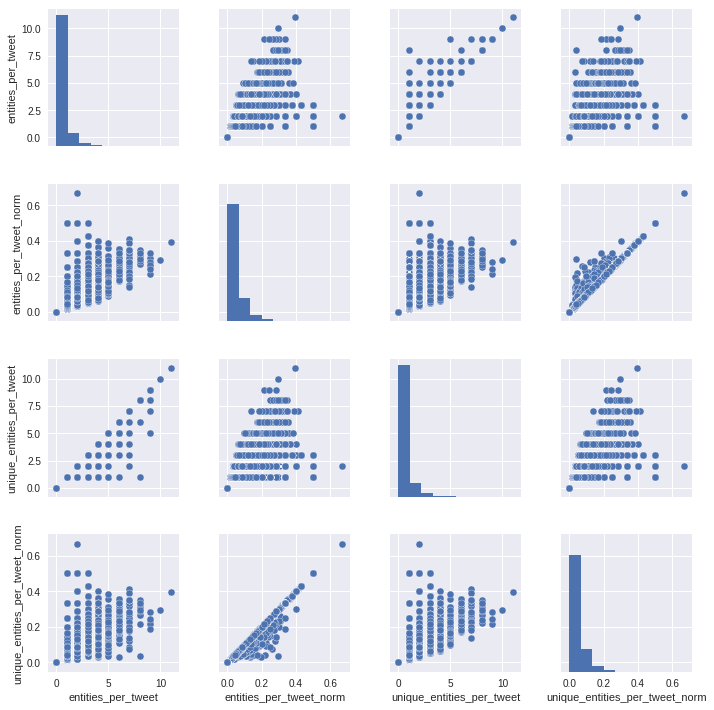

In [91]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
entity_cols = ['entities_per_tweet', 'entities_per_tweet_norm', 'unique_entities_per_tweet', 'unique_entities_per_tweet_norm']
sns.pairplot(tweet_df_valid.loc[:, entity_cols])
plt.show()

**Univariate**: These distributions have a heavy left-tail, since most tweets do not contain an entity mention.

**Multivariate**: As expected, the entities per tweet and unique entities per tweet are highly correlated. Same with normed entities per tweet and normed unique entities per tweet.

## Visualize time series
What does the overall time series for entities per hour look like?

We'll need to round all the dates down to the nearest hour, then compute the aggregate means for entities per tweet.

In [99]:
print(tweet_df_valid.loc[:, 'date'].values[0])

2017-09-18 19:59


In [100]:
from datetime import datetime
date_fmt = '%Y-%m-%d %H:%M'
tweet_df_valid = tweet_df_valid.assign(date_datetime=tweet_df_valid.loc[:, 'date'].apply(lambda x: datetime.strptime(x, date_fmt)))

In [108]:
tweet_df_valid = tweet_df_valid.assign(date_hour=tweet_df_valid.loc[:, 'date_datetime'].apply(lambda x: datetime(*x.timetuple()[:4])))

In [109]:
mean_entities_per_hour = tweet_df_valid.groupby('date_hour').apply(lambda x: x.loc[:, 'entities_per_tweet'].mean())

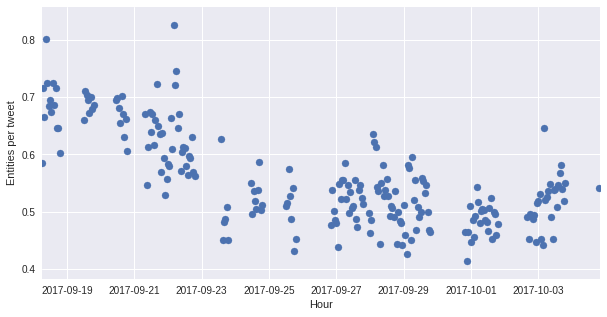

In [112]:
# plot time series
date_min = tweet_df_valid.loc[:, 'date_datetime'].min()
date_max = tweet_df_valid.loc[:, 'date_datetime'].max()
plt.figure(figsize=(10,5))
plt.scatter(mean_entities_per_hour.index, mean_entities_per_hour)
plt.xlim((date_min, date_max))
plt.xlabel('Hour')
plt.ylabel('Entities per tweet')
plt.show()

OK! So it looks like the entities per tweet ratio actually fell during and after the hurricane. Does this hold for all measures of entity frequency?

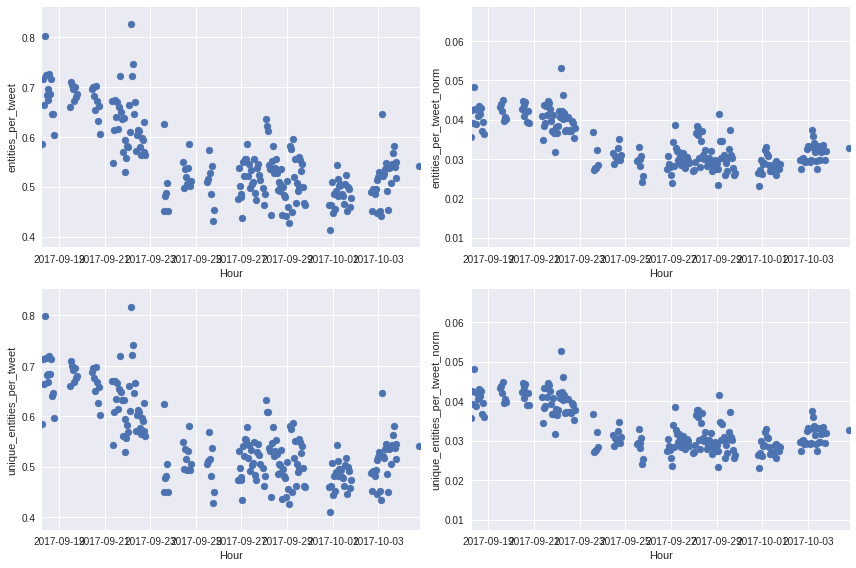

In [118]:
from math import ceil
cols = 2
rows = int(ceil(len(entity_cols) / cols))
fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
for i, entity_col in enumerate(entity_cols):
    mean_entities_per_hour = tweet_df_valid.groupby('date_hour').apply(lambda x: x.loc[:, entity_col].mean())
    r = int(i / cols)
    c = i % cols
    ax = axs[r, c]
    ax.scatter(mean_entities_per_hour.index, mean_entities_per_hour)
    ax.set_xlim((date_min, date_max))
    ax.set_xlabel('Hour')
    ax.set_ylabel(entity_col)
plt.tight_layout()
plt.show()

All the entity statistics follow basically the same trend, so let's stick with $E$ (entities per tweet) as our metric to test.

## Test RQ1
We can formalize RQ1 as a two-part hypothesis test to compare during-hurricane vs. before-hurricane (period B) and during-hurricane vs. after-hurricane (period A).

$H_{0,B}$: The average number of entities per tweet before the hurricane is roughly the same as the average number of entities per tweet during the hurricane.

$H_{1,B}$: The average number of entities per tweet before the hurricane is lower than the average number of entities per tweet during the hurricane.

$H_{0,A}$: The average number of entities per tweet after the hurricane is roughly the same as the average number of entities per tweet during the hurricane.

$H_{1,A}$: The average number of entities per tweet after the hurricane is lower than the average number of entities per tweet during the hurricane.

First we'll need to define what we mean by "before" and "after": we set the end of "before" as the date of landfall on Puerto Rico (9/20/17) and the beginning of "after" as the date of leaving Puerto Rico (9/22/17).

In [122]:
hurricane_start_date = datetime.strptime('2017-09-20 06:00', '%Y-%m-%d %H:%M')
hurricane_end_date = datetime.strptime('2017-09-22 12:00', '%Y-%m-%d %H:%M')

In [124]:
before_data = tweet_df_valid[tweet_df_valid.loc[:, 'date_datetime'] < hurricane_start_date]
during_data = tweet_df_valid[(tweet_df_valid.loc[:, 'date_datetime'] >= hurricane_start_date) &
                             (tweet_df_valid.loc[:, 'date_datetime'] <= hurricane_end_date)]
after_data = tweet_df_valid[tweet_df_valid.loc[:, 'date_datetime'] >= hurricane_end_date]
print('%d tweets before landfall'%(before_data.shape[0]))
print('%d tweets during landfall'%(during_data.shape[0]))
print('%d tweets after landfall'%(after_data.shape[0]))

23158 tweets before landfall
38247 tweets during landfall
158078 tweets after landfall


Let's look at the data in box plot form.

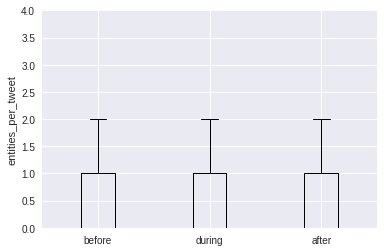

In [132]:
entity_col = 'entities_per_tweet'
time_data_list = [before_data, during_data, after_data]
time_data_labels = ['before', 'during', 'after']
y_min = 0
y_max = 4
plt.boxplot([data.loc[:, entity_col] for data in time_data_list])
plt.xticks(range(1, len(time_data_list)+1), time_data_labels)
plt.ylim((y_min, y_max))
plt.ylabel(entity_col)
plt.show()

This difference doesn't look very promising! But let's see if there is a significant difference between periods using a one-sided t-test.

In [140]:
from itertools import izip
from scipy.stats import ttest_ind

def test_pops(pop_1, pop_2):
    """
    Test difference in means between two populations 
    (one-sided, pop_1 > pop_2).
    
    Parameters:
    -----------
    pop_1 : pandas.Series
    pop_2 : pandas.Series
    
    Returns:
    --------
    diff : float
    t_val : float
    p_val : float
    """
    diff = pop_1.mean() - pop_2.mean()
    t_val, p_val = ttest_ind(pop_1, pop_2)
    # correct for one-tailed by dividing in half
    p_val /= 2.
    return diff, t_val, p_val

# compute means
for data, data_name in izip(time_data_list, time_data_labels):
    data_entity_mean = data.loc[:, entity_col].mean()
    print('data %s has a mean of %.3f entities per tweet'%(data_name, data_entity_mean))
    
data_pairs = [[before_data, during_data], [during_data, after_data]]
data_pair_names = [['before', 'during'], ['during', 'after']]
for data_pair, data_pair_name in izip(data_pairs, data_pair_names):
    diff, t_val, p_val = test_pops(data_pair[0].loc[:, entity_col], 
                                   data_pair[1].loc[:, entity_col])
    print('%s vs. %s difference = %.3f (t=%.3f, p=%.3E)'%(data_pair_name[0], data_pair_name[1], diff, t_val, p_val))

data before has a mean of 0.684 entities per tweet
data during has a mean of 0.644 entities per tweet
data after has a mean of 0.512 entities per tweet
before vs. during difference = 0.040 (t=5.344, p=4.557E-08)
during vs. after difference = 0.132 (t=28.499, p=1.413E-178)


It looks like there actually are significant differences here with the distribution of $E$: 

- Tweets before the hurricane used slightly more entities than tweets during the hurricane.
- Tweets during the hurricane used more entities than tweets after the hurricane.

These are in line with our earlier scatterplots of entities per tweet over time.

**Switch to binary**:

What if we switch from entity counts per tweet (scalar) to entity included in a tweet (binary)? That might show a different pattern.

Let's call this metric $P(E)$ (probability of observing at least one entity in a tweet). We'll use a Z-test to compare the probabilities between time periods.

In [152]:
from scipy.stats import norm
def test_pops_proportion(pop_1, pop_2):
    """
    Test for a significant difference in population
    proportion (assuming all 0s, 1s).
    
    Parameters:
    -----------
    pop_1 : pandas.Series
    pop_2 : pandas.Series
    
    Returns:
    --------
    prop_diff : float
    z_val : float
    p_val : float
    """
    prop_1 = pop_1.mean()
    prop_2 = pop_2.mean()
    n_1 = len(pop_1)
    n_2 = len(pop_2)
    prop_diff = prop_1 - prop_2
    prop_pooled = (n_1*prop_1 + n_2*prop_2) / (n_1 + n_2)
    z_val = (prop_diff) / (prop_pooled*(1-prop_pooled)*(1/n_1 + 1/n_2))**.5
    p_val = 1 - norm.cdf(z_val)
    return prop_diff, z_val, p_val

# compute binary variable
tweet_df_valid = tweet_df_valid.assign(has_entity=(tweet_df_valid.loc[:, 'entities_per_tweet'] > 0).astype(int))

# recompute data
before_data = tweet_df_valid[tweet_df_valid.loc[:, 'date_datetime'] < hurricane_start_date]
during_data = tweet_df_valid[(tweet_df_valid.loc[:, 'date_datetime'] >= hurricane_start_date) &
                             (tweet_df_valid.loc[:, 'date_datetime'] <= hurricane_end_date)]
after_data = tweet_df_valid[tweet_df_valid.loc[:, 'date_datetime'] >= hurricane_end_date]

# compute proportions
entity_proportion_col = 'has_entity'
data_list = [before_data, during_data, after_data]
data_names = ['before', 'during', 'after']
for data, data_name in izip(data_list, data_names):
    prop_mean = data.loc[:, entity_proportion_col].mean()
    prop_std = prop_mean*(1-prop_mean) / (data.shape[0])**.5
    print('%s proportion %.3f +/- %.3f'%(data_name, prop_mean, prop_std))

# organize data for proportion test
data_pairs = [[before_data, during_data], [during_data, after_data]]
data_pair_names = [['before', 'during'], ['during', 'after']]
for data_pair, data_pair_name in izip(data_pairs, data_pair_names):
    diff, t_val, p_val = test_pops_proportion(data_pair[0].loc[:, entity_proportion_col], 
                                              data_pair[1].loc[:, entity_proportion_col])
    print('%s vs. %s proportion difference = %.3f (t=%.3f, p=%.3E)'%(data_pair_name[0], data_pair_name[1], diff, t_val, p_val))

before proportion 0.470 +/- 0.002
during proportion 0.437 +/- 0.001
after proportion 0.371 +/- 0.001
before vs. during proportion difference = 0.032 (t=7.742, p=4.885E-15)
during vs. after proportion difference = 0.067 (t=24.058, p=0.000E+00)


The proportion test reinforces earlier results! It's good, because now we know that the earlier results probably weren't skewed by unusually high entity counts.

- Tweets before the hurricane were slightly more likely to use at least one entity than tweets during the hurricane.
- Tweets during the hurricane were more likely to use at least one entity than tweets during the hurricane.

**RQ1 conclusion**:

We find that both (1) the average number of entities and (2) the probability of seeing at least one entity was higher before Hurricane Maria than during Hurricane Maria, which was higher than after Hurricane Maria. This was somewhat unexpected, because I thought that the crisis would attract more attention during landfall in Puerto Rico rather than before landfall. 

A possible explanation: many of the named entities used before the hurricane could be related to hurricane preparation. The next section could help address this by looking at the distribution of entities during different time periods.

## Compute entity distribution

We now address RQ2 by testing the *distribution* of entities at different points of the crisis. I expect that the discussion included a more diverse range of entity mentions during hurricane landfall as compared to before (B) and after (A) the hurricane, because I expect that those discussing the hurricane would either be reporting on its progress (more location names) or would be requesting information about people in the middle of the hurricane (more location names).

$H_{0,B}$: The distribution of entities before the hurricane is equally diverse as the distribution of entities during the hurricane.

$H_{1,B}$: The distribution of entities before the hurricane is less diverse than the diversity of entities during the hurricane.

$H_{0,A}$: The distribution of entities after the hurricane is equally diverse as the distribution of entities during the hurricane.

$H_{1,A}$: The distribution of entities after the hurricane is less diverse than the diversity of entities during the hurricane.

To approximate the distribution of entities, we compute the following two metrics:

- entropy (per time period)
- cosine similarity (between time periods)

Under the alternative hypothesis, we expect that the entropy over named entities is significantly greater (higher entropy => less predictable => more diversity) and that the cosine similarity is lower than expected by chance.

We'll need to recompute the entity DTM, because when we first computed it we didn't sort the data by date.

In [160]:
tweet_df_valid.sort_values('date_datetime', inplace=True)
tweet_data_entity_lists = tweet_df_valid.loc[:, 'text_tagged'].apply(lambda x: collect_entities_from_txt(x))
tweet_data_entity_lists_joined = map(lambda x: ' '.join(x), tweet_data_entity_lists)
token_pattern = '\S+'
cv = CountVectorizer(min_df=1, lowercase=False, strip_accents=None, token_pattern=token_pattern)
entity_dtm = cv.fit_transform(tweet_data_entity_lists_joined)

First we'll split the DTM into the before, during and after periods.

In [186]:
before_end_idx = pd.np.where(tweet_df_valid.loc[:, 'date_datetime'] >= hurricane_start_date)[0][0]
after_start_idx = pd.np.where(tweet_df_valid.loc[:, 'date_datetime'] > hurricane_end_date)[0][0]

In [172]:
before_entity_dtm = entity_dtm[:before_end_idx, ]
during_entity_dtm = entity_dtm[before_end_idx:after_start_idx, ]
after_entity_dtm = entity_dtm[after_start_idx:, ]

In [187]:
print('%d before tweets'%(before_entity_dtm.shape[0]))
print('%d during tweets'%(during_entity_dtm.shape[0]))
print('%d after tweets'%(after_entity_dtm.shape[0]))

23158 before tweets
38247 during tweets
158057 after tweets


Next, we'll convert these DTMs into probabilities.

In [229]:
def convert_to_prob(dtm):
#     return dtm.sum(axis=0) / dtm.sum().sum()
    dtm_prob = pd.np.array(dtm.sum(axis=0) / dtm.sum().sum())[0]
    return dtm_prob
before_entity_probs = convert_to_prob(before_entity_dtm)
during_entity_probs = convert_to_prob(during_entity_dtm)
after_entity_probs = convert_to_prob(after_entity_dtm)

Just out of curiosity, what were the highest-probability entities during each time period? We really should have looked at this earlier.

In [181]:
data_prob_list = [before_entity_probs, during_entity_probs, after_entity_probs]
data_name_list = ['before', 'during', 'after']
top_k = 10
ivoc = {v : k for k,v in cv.vocabulary_.iteritems()}
for data_probs, data_name in izip(data_prob_list, data_name_list):
    top_k_entities = [ivoc[i] for i in pd.np.array(data_probs.argsort())[0][::-1][:top_k]]
    print('%s hurricane has top entities:\n%s'%(data_name, '\n'.join(top_k_entities)))

before hurricane has top entities:
Puerto_Rico
Maria
Dominica
#Maria
#Dominica
Irma
PR
Virgin_Islands
Hurricane_Maria
Leeward_Islands
during hurricane has top entities:
Puerto_Rico
Maria
PR
San_Juan
#Dominica
Dominica
Hurricane_Maria
Turks
Mexico
María
after hurricane has top entities:
Puerto_Rico
Trump
PR
San_Juan
Jones_Act
Maria
America
Katrina
Florida
Puerto_Ricans


It looks like locations dominate throughout the data (`Puerto_Rico`, `Dominica`, `San_Juan`) and the focus shifts more toward America's response after the hurricane (`Trump`, `Jones_Act`, `America`).

Let's define some formulae for computing entropy and cosine similarity.

In [233]:
def compute_entropy(data):
    data_smooth = pd.np.log(data.T+1)
    entropy = data.dot(data_smooth)
    return entropy
def compute_cosine_similarity(data_1, data_2):
    cosine_sim = data_1.dot(data_2.T) / ((pd.np.linalg.norm(data_1)) * (pd.np.linalg.norm(data_2)))
#     cosine_sim = cosine_sim[0]
    return cosine_sim
def compute_statistics(data_1, data_2):
    entropy_1 = compute_entropy(data_1)
    entropy_2 = compute_entropy(data_2)
    cosine = compute_cosine_similarity(data_1, data_2)
    return entropy_1, entropy_2, cosine

Now let's compute the statistics for all pairs of interest (before versus during, during versus after).

In [211]:
data_pairs = [[before_entity_probs, during_entity_probs], [during_entity_probs, after_entity_probs]]
data_pair_names = [['before', 'during'], ['during', 'after']]
for data_pair, data_names in izip(data_pairs, data_pair_names):
    entropy_1, entropy_2, cosine = compute_statistics(*data_pair)
    entropy_diff = entropy_1 - entropy_2
    print('data pair %s vs. %s has entropy diff=%.3E, cosine=%.3E'%
          (data_names[0], data_names[1], entropy_diff, cosine))

data pair before vs. during has entropy diff=-1.182E-02, cosine=9.366E-01
data pair during vs. after has entropy diff=1.636E-02, cosine=8.346E-01


At first glance:

- During-hurricane has higher entropy than before-hurricane and a high similarity between periods.
- During-hurricane has higher entropy than after-hurricane, and a somewhat high similarity between periods.

Now we need to figure out if these comparison metrics are significant according to chance.

I can't come up with a parametric test for significance in comparing the different time periods, but I think the following nonparametric test will help us out:

0. Compute the actual entropy differences and cosine similarities.
1. Compute the split indices (corresponding to rows in the entity DTM) for before, during and after the hurricane: call the before/during split point $S_{b,d}$ and the during/after split point $S_{d,a}$.
2. Shuffle the entity DTM.
3. Extract a new version of the "before", "during" and "after" data from the shuffled entity DTM using $S_{b,d}$ and $S_{d,a}$.
4. Compute the entropy and cosine similarity as before.
5. Repeat 2-5 X times.
6. Count the number of times that the shuffled entropy and cosine similarities are more extreme than the actual values.
7. p-value = count / X. (probability of erroneously rejecting the null hypothesis)

In [208]:
# first get split indices
before_end_idx = pd.np.where(tweet_df_valid.loc[:, 'date_datetime'] >= hurricane_start_date)[0][0]
after_start_idx = pd.np.where(tweet_df_valid.loc[:, 'date_datetime'] > hurricane_end_date)[0][0]

In [243]:
from collections import defaultdict
entity_dtm_shuffle = entity_dtm.copy()
entity_dtm_idx = pd.np.arange(entity_dtm_shuffle.shape[0])
iter_count = 5000
# need separate count list for each hypothesis (before vs. during, during vs. after)
data_pair_entropy_diff = defaultdict(list)
data_pair_cosine_sim = defaultdict(list)
data_pair_names = ['before_during', 'during_after']
for i in range(iter_count):
    pd.np.random.shuffle(entity_dtm_idx)
    entity_dtm_shuffle = entity_dtm_shuffle[entity_dtm_idx, :]
    before_dtm_shuffle = entity_dtm_shuffle[:before_end_idx, :]
    during_dtm_shuffle = entity_dtm_shuffle[before_end_idx:after_start_idx, :]
    after_dtm_shuffle = entity_dtm_shuffle[after_start_idx:, :]
    # compute probs
    before_shuffle_probs = convert_to_prob(before_dtm_shuffle)
    during_shuffle_probs = convert_to_prob(during_dtm_shuffle)
    after_shuffle_probs = convert_to_prob(after_dtm_shuffle)
    data_pairs = [[before_shuffle_probs, during_shuffle_probs], 
                  [during_shuffle_probs, after_shuffle_probs]]
    for data_pair, data_pair_name in izip(data_pairs, data_pair_names):
        entropy_1, entropy_2, cosine = compute_statistics(*data_pair)
        entropy_diff = entropy_1 - entropy_2
        data_pair_entropy_diff[data_pair_name].append(entropy_diff)
        data_pair_cosine_sim[data_pair_name].append(cosine)
    if(i % 1000 == 0):
        print('done with iter %d'%(i))

done with iter 0
done with iter 1000
done with iter 2000
done with iter 3000
done with iter 4000


Now we count the number of times that the shuffled statistics are more extreme, and the normalized count becomes our p-value.

In the case of before vs. during ($H_{B}$): we count the number of times that the shuffled entropy difference is less than the computed difference (before - during), and the number of times that the shuffled cosine similarity is less than the computed similarity.

In the case of during vs. after ($H_{A}$): we count the number of times that the shuffled entropy difference is greater than the computed difference (after - during), and the number of times that the shuffled cosine similarity is less than the computed similarity.

In [244]:
from __future__ import division
data_pairs = [[before_entity_probs, during_entity_probs], [during_entity_probs, after_entity_probs]]
# before-during first
entropy_1, entropy_2, cosine_b_d = compute_statistics(before_entity_probs, during_entity_probs)
entropy_diff_b_d = entropy_1 - entropy_2
# pvals
cosine_b_d_pval = len([c for c in data_pair_cosine_sim['before_during'] if c < cosine_b_d]) / iter_count
entropy_diff_b_d_pval = len([e for e in data_pair_entropy_diff['before_during'] if e < entropy_diff_b_d]) / iter_count
print('before vs. during p-values: entropy diff=%.3E, cosine=%.3E'%(cosine_b_d_pval, entropy_diff_b_d_pval))
# during-after second
entropy_1, entropy_2, cosine_d_a = compute_statistics(during_entity_probs, after_entity_probs)
entropy_diff_d_a = entropy_1 - entropy_2
# pvals
cosine_d_a_pval = len([c for c in data_pair_cosine_sim['during_after'] if c < cosine_d_a]) / iter_count
entropy_diff_d_a_pval = len([e for e in data_pair_entropy_diff['during_after'] if e > entropy_diff_d_a]) / iter_count
print('during vs. after p-values: entropy diff=%.3E, cosine=%.3E'%(cosine_d_a_pval, entropy_diff_d_a_pval))

before vs. during p-values: entropy diff=0.000E+00, cosine=0.000E+00
during vs. after p-values: entropy diff=0.000E+00, cosine=0.000E+00


These p-values seem weirdly low! I tried inspecting the actual computed cosine similarities and entropy differences to make sure that they weren't all identical and this is not the case.

**Conclusion:**

We can reject both $H_{0,B}$ and $H_{0,A}$ and state that:

- During the hurricane, the distribution of named entities was more diverse than before the hurricane, and the two distributions were less similar than chance.
- During the hurricane, the distribution of named entities was more diverse than after the hurricane, and the two distributions were much less similar than chance.

This suggests (1) during the hurricane a wider range of entities was mentioned, e.g. more specific locations in Puerto Rico, or (2) before/after the hurricane the distribution of entities was spikier, e.g. focusing heavily on the entity `Puerto_Rico`.

## Conclusion

We can conclude that there were more named entity mentions at the beginning of Hurricane Maria as compared with the end of Hurricane Maria (**RQ1**). Furthermore, we found that during the hurricane, the distribution of entity mentions was more diverse than before and after the hurricane, and that the distribution was less similar to before/after than expected by chance (**RQ2**). This suggests further inspection to determine if these macro-level differences in named entity usage can differentiate different stages of crisis (Houston et al. 2015).

## Discussion

I assume in this analysis that most of the tweets relating to Hurricane Maria were about Puerto Rico, such as the start and end date of the hurricane were the landfall dates for Puerto Rico, and many of the entities related to Puerto Rico (`Puerto_Rico`, `PR`, `Puerto_Ricans`). However we saw even from preliminary analysis that some of the content is about other areas, including Dominica, which suggests either (1) a wider time window of data for testing or (2) a more restricted dataset that only includes content about one location.

I was unable to generate entity classes for the English data (errors in the tagger), and it would have been interesting to compare the distribution of classes before, during and after the hurricane. For instance, I would expect more specific locations to be mentioned during the hurricane and more organizations to be mentioned afterward (e.g., relief organizations), corresponding to the different stages of crisis. I would also expect more reporting on named entities by official news organizations after the hurricane (i.e., once the details are settled), as compared to during the hurricane when (1) locals report on their own conditions and (2) outsiders speculate about entities that could be affected.

In this unique bilingual situation, I should have tried splitting the English and Spanish tweets to determine if the proportion of entities was equal in both languages and if the overall trends in entity usage followed the same decreasing pattern we saw before.

In a non-time related direction, I would be interested to see whether tweets that include entities are more likely to be retweeted. One could imagine that since information is at a premium during a crisis, Twitter users would be more likely to retweet new information in the form of named entities. However, this might only apply for new entities in the long tail of low-frequency names, which would make prediction harder.

### References
J. B. Houston et al. (2015). Social media and disasters: A functional framework for social media use in disaster planning, response, and research. Disasters, 39(1), 1–22.

Ritter, A., Clark, S., & Etzioni, O. (2011). Named Entity Recognition in Tweets: An Experimental Study. In EMNLP (pp. 1524–1534). 

Sarcevic, A., Palen, L., White, J., Starbird, K., Bagdouri, M., & Anderson, K. M. (2012). Beacons of Hope in Decentralized Coordination: Learning from On-the-Ground Medical Twitterers During the 2010 Haiti Earthquake. In Proceedings of the ACM 2012 conference on Computer Supported Cooperative Work (pp. 47–56). 

Starbird, K., Muzny, G., & Palen, L. (2012). Learning from the crowd: Collaborative filtering techniques for identifying on-the-Ground Twitterers during mass disruptions. Proceedings of 9th International Conference on Information Systems for Crisis Response and Management, ISCRAM, (April), 1–10. 